In [231]:
import torch
from torch import nn
import circuits as ckt
import learn as lrn
from models import Solver
from models import State
from inputs import Input

In [232]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(precision=2, linewidth=200)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 2 nodes and 2 elements
[0, 1]
[(1 , 0), (1 , 0)]
[(1, {}), (0, {})]
[(1, 0, 0, {'kind': <Kinds.IVS: 0>, 'i': None, 'v': None, 'attr': 1}), (1, 0, 1, {'kind': <Kinds.R: 2>, 'i': 10, 'v': None, 'attr': None})]


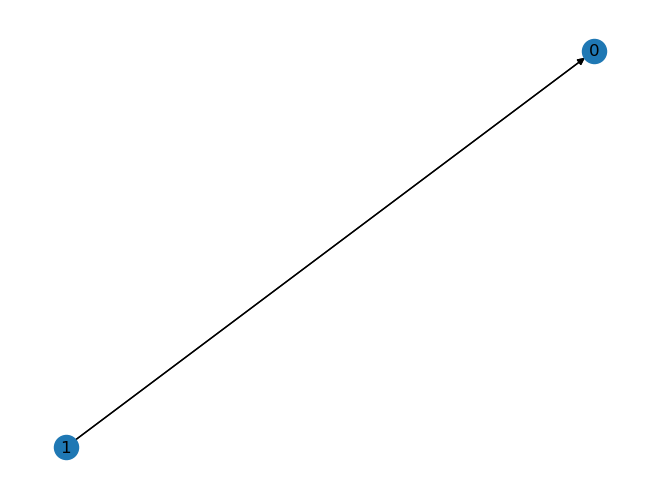

In [233]:
vr = ckt.Circuit()

v_source = vr.add_element(kind=ckt.Kinds.IVS)
r1 = vr.add_element(kind=ckt.Kinds.R)
v_source.connect(v_source.high, r1.high)
v_source.connect(v_source.low, r1.low)
# Case 1 all resistances known
# v_source.attr = 1
# r1.attr = 1e6
# Case 2 one resisance unknown
# v_source.attr = 1
# v_source.i = -1e4
# Case 3 one voltage and one current known
v_source.attr = 1
r1.i = 10

# v_source = vr.add_element(kind=ckt.Kinds.IVS)
# r1 = vr.add_element(kind=ckt.Kinds.R)
# r2 = vr.add_element(kind=ckt.Kinds.R)
# v_source.connect(v_source.high, r1.high)
# r1.connect(r1.low, r2.high)
# v_source.connect(v_source.low, r2.low)
# # # Case 1 all resistances known
# v_source.attr = 1
# r1.attr = 1e6
# r2.attr = 1e6
# # # Case 2 one resisance unknown
# # v_source.attr = 1
# # r1.attr = 10
# # r2.v = 0.5

print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Create Solver

In [234]:
input = Input(vr)

In [235]:
import time
start_time = time.time()
model = Solver(input=input,attr=input.attr_param, state=State.Solve)
X = model()
end_time = time.time()
X

tensor([[-1.46],
        [ 1.46],
        [ 1.00],
        [ 1.00],
        [-1.00]], grad_fn=<LinalgSolveExBackward0>)

In [236]:
print(f'execution time = {(end_time - start_time)*1000} ms')

execution time = 2.986431121826172 ms


# Learn attributes

In [237]:
num_epochs = 1000
prev_loss = 0.1

model = Solver(input=input, attr=input.attr_param, state=State.Solve)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)
loss, _ = lrn.train(model,optimizer,nn.MSELoss())
print(f'init params: {input.attr_param}')
print(f'init loss: {loss.item()}')

epoch = 0

while(epoch < num_epochs):
    loss, _ = lrn.train(model,optimizer,nn.MSELoss())
    if(loss < 1e-6):
            break
    epoch += 1
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

print(f'Done! at {epoch} passes')
print(f'solution = {model()}')
print(f"attributes = {input.attr_param}")

init params: Parameter containing:
tensor([[1.00],
        [0.67]], requires_grad=True)
init loss: 72.91527557373047
Done! at 165 passes
solution = tensor([[-10.00],
        [ 10.00],
        [  1.00],
        [  1.00],
        [ -1.00]], grad_fn=<LinalgSolveExBackward0>)
attributes = Parameter containing:
tensor([[1.00],
        [0.10]], requires_grad=True)


In [238]:
A,b = model.build(True)

In [239]:
A

tensor([[-1.00, -1.00,  0.00,  0.00,  0.00,  0.00],
        [ 1.00,  1.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  1.00,  0.00,  1.00, -1.00],
        [ 0.00,  0.00,  0.00,  1.00,  1.00, -1.00],
        [ 0.00,  0.00,  1.00,  0.00,  0.00,  0.00],
        [ 0.00, -0.10,  0.00,  1.00,  0.00,  0.00],
        [ 0.00,  1.00,  0.00,  0.00,  0.00,  0.00]], grad_fn=<CatBackward0>)

In [240]:
b

tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 0.],
        [10.]], grad_fn=<CatBackward0>)